# **Forecasting Cannabis Retail Sales with Machine Learning**

---

## Authors: Tae Sakong and Kevin Lasenberry

***
### **Introduction**
Since 1995, 35 states legalized the medical use and 15 states legalized the recreational use of cannabis (“Several States have legalized, 2019). Subsequently, the changing legal and policy landscape of cannabis gave rise to changing dynamics in cannabis-use in the United States. From
2002-2015, there was a significant increase in cannabis use across all sociodemographic groups; including age, race, socioeconomic status, marital status, and region (Hasin & Walsh, 2021).From 2010-2016, adult-use cannabis increased by 30 percent from $25 million to $32 million, with a 24% increase in cannabis spending from $42 billion to $52 billion (Midgette et. al, 2019).
In terms of value-added to GDP in 2019, the cannabis industry adds $4 billion to the farm sector, $8 billion to the food,beverage, and tobacco manufacturing sector, and $37 billion dollars to the retail sector (Soloveichick, 2021).

### **Relevance**
Clearly, the substantial increase in cannabis-use and cannabis-related expenditures hallmark the importance of studying the sale of cannabis products. Given the current scale of cannabisusers, the study of cannabis product sales has important implications on public health, state tax
revenues, and the retail sectors of industry.

### **Problem Statement**
Currently, there are few open-source datasets that provide quantiative analyses of the dyanmics of cannabis product sales at the state level. Specifically, there is a gap in knowledge with respect to algorithms that are optimized for forecasting cannabis product sales. The regulatory and
compliance standard further highlight the need to properly evaluate and forecast proper levels of cannabis product manufacturing and distribution. Whether to audit correct cannabis state tax revenues, track changing consumer cannabis usage for public health reasons, or regulate the economic activity of the cannabis retail sector. The fact remains the same: few studies have
evaluated and optimized algorithms to forecast cannabis product sales.

### **Research Question**
How do total cannabis product sales change over time? More specifically, how do total cannabis product sales change over time with respect to product type?

### **Approach**
The approach will involve time series analysis and forecasting. We’ll first conduct exploratory data analysis (EDA) to understand the underlying patterns and trends in the total cannabis product sales and by cannabis product type. EDA will also help uncover seasonality, trends, and potential anomalies in the data. Following EDA, we’ll apply several time series forecasting
techniques, including single exponential smoothing and Auto-ARIMA to predict future sales. For the specific research question about product type sales, separate EDA and time series analysis will be conducted for each product type. This will help us identify if certain products have distinct seasonality or trends that differ from the overall cannabis market.

## Table of Contents

---

1. Data Summary
2. Process the data
3. Clean the data
4. Exploratory Data Analysis
5. Time Series Forecasting
    - Develop a model
        - Single exponential Smoothing
        - ARIMA
    - Train the model
    - Evaluate Models: Single Exponential Smoothing vs ARIMA
6. Results
7. Implications
8. Directions for Future Research

## Dataset Summary

--- 


a. [Cannabis Retail Sales by Week Ending](https://catalog.data.gov/dataset/cannabis-retail-sales-by-week-ending)

  *Original Purpose of Data*
  
  > This data set contains weekly retail sales data for cannabis and cannabis products in both the adult-use cannabis and medical marijuana markets for the State of Connecticut. The data was collected at weekly intervals for each month for the period from January, 2023 to August, 2023. The purpose of the datset was to monitor the total cannabis retail sales in the State of Connecticut.
  
  *Date of Data Collection*
    
  > October 10, 2023
    
  *Number of Variables in Original Data*
  
  > 9
  
  *Data Peculiarities*
    
  > Last row is a tabulated total for each column
    
b. [Cannabis Retail Products Sold by Product Type](https://catalog.data.gov/dataset/cannabis-retail-products-sold-by-product-type)

  *Original Purpose of Data*
  
  > This data set contains weekly sales data for cannabis and cannabis products by product type in the adult-use cannabis and medical marijuana markets based on total sales data. The data was collectet once each month for the period from January, 2023 to October, 2023. The purpose of this dataset was to monitor the cannabis retail sales for each product type in the State of Connecticut.
  
  *Date of Data Collection*
    
  > October 10, 2023
    
  *Number of Variables in Original Data*
  
  > 4
    
  *Data Peculiarities*
  
  > No missing values are reported. However, date variable will need to be converted to date-time objects.
    

In [16]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns

import scipy.stats as scs
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from dateutil.relativedelta import relativedelta
from datetime import datetime
from dateutil import parser


import warnings
from itertools import product

import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
%matplotlib inline

## Data Processing:

---

1. Total Cannabis Sales ("sales_df")
2. Total Cannabis Retail Sales by Product Type ("product_df")

### 1. Import the data - Total Cannabis Sales

In [17]:
# URL for total cannabis sales
url_sales = "https://data.ct.gov/api/views/ucaf-96h6/rows.csv?accessType=DOWNLOAD"

# Convert csv to dataframe
sales_df = pd.read_csv(url_sales)

In [18]:
# Inspect the dataframe
sales_df.head()

,Week Ending,Adult-Use Retail Sales,Medical Marijuana Retail Sales,Total Adult-Use and Medical Sales,Adult-Use Products Sold,Medical Products Sold,Total Products Sold,Adult-Use Average Product Price,Medical Average Product Price
0,01/14/2023,1485019.32,1776700.69,3261720.01,33610.0,49312.0,82922.0,44.25,36.23
1,01/21/2023,1487815.81,2702525.61,4190341.42,33005.0,77461.0,110466.0,45.08,34.89
2,01/28/2023,1553216.30,2726237.56,4279453.86,34854.0,76450.0,111304.0,44.56,35.65
3,01/31/2023,578840.62,863287.86,1442128.48,12990.0,24023.0,37013.0,44.56,35.93
4,02/04/2023,1047436.20,1971731.40,3019167.60,24134.0,56666.0,80800.0,43.49,34.84


In [19]:
# Check datatypes and variables
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Week Ending                        51 non-null     object 
 1   Adult-Use Retail Sales             52 non-null     float64
 2   Medical Marijuana Retail Sales     52 non-null     float64
 3   Total Adult-Use and Medical Sales  52 non-null     float64
 4   Adult-Use Products Sold            51 non-null     float64
 5   Medical Products Sold              51 non-null     float64
 6   Total Products Sold                51 non-null     float64
 7   Adult-Use Average Product Price    51 non-null     float64
 8   Medical Average Product Price      51 non-null     float64
dtypes: float64(8), object(1)
memory usage: 3.8+ KB


In [20]:
# Check for missing values
sales_df.isnull().sum()

Week Ending                          1
Adult-Use Retail Sales               0
Medical Marijuana Retail Sales       0
Total Adult-Use and Medical Sales    0
Adult-Use Products Sold              1
Medical Products Sold                1
Total Products Sold                  1
Adult-Use Average Product Price      1
Medical Average Product Price        1
dtype: int64

In [21]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Week Ending                        51 non-null     object 
 1   Adult-Use Retail Sales             52 non-null     float64
 2   Medical Marijuana Retail Sales     52 non-null     float64
 3   Total Adult-Use and Medical Sales  52 non-null     float64
 4   Adult-Use Products Sold            51 non-null     float64
 5   Medical Products Sold              51 non-null     float64
 6   Total Products Sold                51 non-null     float64
 7   Adult-Use Average Product Price    51 non-null     float64
 8   Medical Average Product Price      51 non-null     float64
dtypes: float64(8), object(1)
memory usage: 3.8+ KB


### 2. Import the Data - Total Cannabis Sales by Product Type

In [22]:
# URL for total cannabis sales by product type
url_products = "https://data.ct.gov/api/views/jyg4-yu7v/rows.csv?accessType=DOWNLOAD"

# Convert csv to dataframe
product_df = pd.read_csv(url_products)

In [23]:
# Inspect the dataframe
product_df.head()

,Month Ending,Product Type,Retail Sales Amount,Market
0,January 2023,Usable Cannabis (Flower),2819150.84,Adult-Use
1,January 2023,Vape Cartridge,721223.06,Adult-Use
2,January 2023,Infused Edible,688928.99,Adult-Use
3,January 2023,Extract for Inhalation,868829.67,Adult-Use
4,January 2023,Usable Cannabis (Flower),4343508.44,Medical


In [24]:
# Check datatypes and variables
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Month Ending         90 non-null     object 
 1   Product Type         90 non-null     object 
 2   Retail Sales Amount  90 non-null     float64
 3   Market               90 non-null     object 
dtypes: float64(1), object(3)
memory usage: 2.9+ KB


In [25]:
# Check for missing values
product_df.isnull().sum()

product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Month Ending         90 non-null     object 
 1   Product Type         90 non-null     object 
 2   Retail Sales Amount  90 non-null     float64
 3   Market               90 non-null     object 
dtypes: float64(1), object(3)
memory usage: 2.9+ KB


## 2. Clean Data

---

1. Total Cannabis Sales ("sales_df")
    - Convert "Week Ending" to datetime datatype, set as datetime index
    - Delete last row containing column totals
2. Total Cannabis Retail Sales by Product Type ("product_df")
    - Convert "Month Ending" to datetime datatype, set as datetime index
    - Convert "Product Type" to factor datatype
    - Convet "Market" to factor datatype


In [26]:
sales_df.head()

,Week Ending,Adult-Use Retail Sales,Medical Marijuana Retail Sales,Total Adult-Use and Medical Sales,Adult-Use Products Sold,Medical Products Sold,Total Products Sold,Adult-Use Average Product Price,Medical Average Product Price
0,01/14/2023,1485019.32,1776700.69,3261720.01,33610.0,49312.0,82922.0,44.25,36.23
1,01/21/2023,1487815.81,2702525.61,4190341.42,33005.0,77461.0,110466.0,45.08,34.89
2,01/28/2023,1553216.30,2726237.56,4279453.86,34854.0,76450.0,111304.0,44.56,35.65
3,01/31/2023,578840.62,863287.86,1442128.48,12990.0,24023.0,37013.0,44.56,35.93
4,02/04/2023,1047436.20,1971731.40,3019167.60,24134.0,56666.0,80800.0,43.49,34.84


In [27]:
# Convert Week Ending to Datetime
sales_df['Week Ending'] = pd.to_datetime(sales_df['Week Ending'])

# Set Week ending to datetimeindex
sales_df.index = pd.PeriodIndex(sales_df['Week Ending'],freq = 'W')

# Extract year, month, and week for plotting
sales_df['Month'] = sales_df['Week Ending'].dt.month
sales_df['Week'] = sales_df['Week Ending'].dt.isocalendar().week

# Delete last row containing column totals
sales_df = sales_df[:-1]

# Check datatypes after type conversion
sales_df.info()


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 51 entries, 2023-01-09/2023-01-15 to 2023-10-30/2023-11-05
Freq: W-SUN
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Week Ending                        51 non-null     datetime64[ns]
 1   Adult-Use Retail Sales             51 non-null     float64       
 2   Medical Marijuana Retail Sales     51 non-null     float64       
 3   Total Adult-Use and Medical Sales  51 non-null     float64       
 4   Adult-Use Products Sold            51 non-null     float64       
 5   Medical Products Sold              51 non-null     float64       
 6   Total Products Sold                51 non-null     float64       
 7   Adult-Use Average Product Price    51 non-null     float64       
 8   Medical Average Product Price      51 non-null     float64       
 9   Month                              51 non-null     float64 

In [28]:
# Convert Month Ending to datetime
product_df['Month Ending'] = pd.to_datetime(product_df["Month Ending"], format = "%B %Y")

# Set Month Ending as Datetime Index
product_df.index = pd.PeriodIndex(product_df['Month Ending'],freq='M')

# Convert 'Product Type' and 'Market' to categorical variables
product_df['Product Type'] = pd.Categorical(product_df['Product Type'])
product_df['Market'] = pd.Categorical(product_df['Market'])

# Extract Month from Month Ending
product_df['Month'] = product_df['Month Ending'].dt.month

# Mapping of old category labels to shortened labels for product type
product_labels = {
    'Extract for Inhalation': 'Extract',
    'Infused Edible': 'Edible',
    'Other (Pill, Capsule, Non Smokable Infused Extract, Tincture, Marijuana Infused Topicals, Liquid Marijuana RSO, Marijuana Mix Infused, Lozenge)': 'Other',
    'Usable Cannabis (Flower)': 'Flower',
    'Vape Cartridge': 'Cartridge'
}

# Apply the new labels
product_df['Product Type'] = product_df['Product Type'].cat.rename_categories(product_labels)


# Check datatypes after type conversion
product_df.info()


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 90 entries, 2023-01 to 2023-10
Freq: M
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Month Ending         90 non-null     datetime64[ns]
 1   Product Type         90 non-null     category      
 2   Retail Sales Amount  90 non-null     float64       
 3   Market               90 non-null     category      
 4   Month                90 non-null     int64         
dtypes: category(2), datetime64[ns](1), float64(1), int64(1)
memory usage: 3.3 KB


**Data Cleaning Summary:**

## Exploratory Data analysis

---

1a. Total Cannabis Retail Sales Over Time for Adult-Use and Medical Marijuana

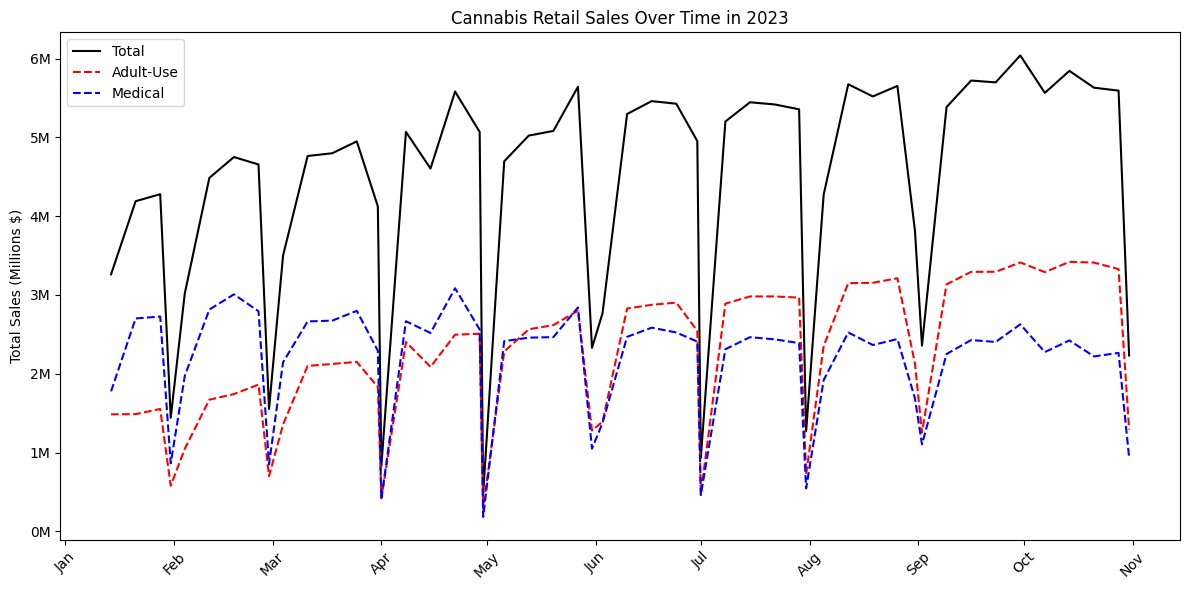

In [29]:
# Plot with adjusted y-axis limits
plt.figure(figsize=(12, 6))
plt.plot(sales_df['Week Ending'], sales_df['Total Adult-Use and Medical Sales'], color="black", label = 'Total')
plt.plot(sales_df['Week Ending'], sales_df['Adult-Use Retail Sales'],linestyle='--', label='Adult-Use', color='red')
plt.plot(sales_df['Week Ending'], sales_df['Medical Marijuana Retail Sales'],linestyle='--', label='Medical', color='blue')
plt.title('Cannabis Retail Sales Over Time in 2023')
plt.ylabel('Total Sales (Millions $)')

# Adjust y-axis values
# Function to format the y-axis tick labels as raw values
def millions_formatter(x, pos):
    return f'{int(x / 1e6)}M'
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))


# Adjusting the x-axis ticks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().tick_params(which='minor', length=4, labelsize=0)
plt.legend()
plt.ylim()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***Analysis: Total Retail Sales over Time***

Total retail sales over time show an increasing trend throughout the year. More importantly, total retail sales over time illustrate fluctutations at specific intervals, approximately on a triweekly basis. 

Some trends illustrated in total retail sales over time are not preserved when investigating total retail sales between adult-use and medical cannabis. Total retail sales for adult-use cannabis shows a decreasing trend over, whereas medical cannaibs shows an increasing trend over time.

However, the periodic fluctuations in total retail sales is similarly observed even when examining total retail sales for adult-use and medical cannabis over time. 

1b. Boxplot of Adult-Use vs Medical Marijuana Total Retail Sales

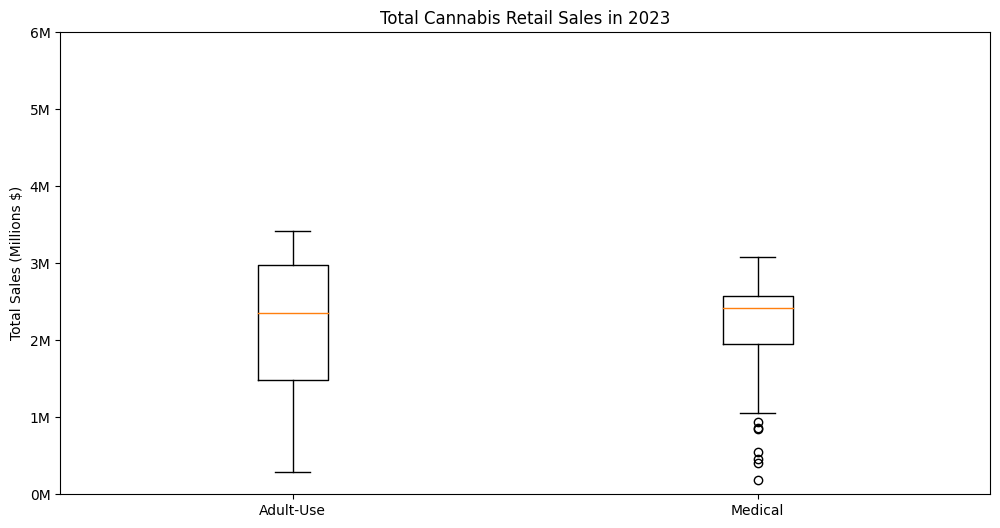

In [30]:
# Creating the boxplot with an increased y-axis maximum
plt.figure(figsize=(12, 6))
plt.boxplot([sales_df['Adult-Use Retail Sales'], sales_df['Medical Marijuana Retail Sales']], labels=['Adult-Use', 'Medical'])
plt.title('Total Cannabis Retail Sales in 2023')
plt.ylabel('Total Sales (Millions $)')
plt.ylim(0,6000000)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.show()

***Analysis: Total Retail Sales between Adult-Use and Medical Cannabis***

The average total sales of adult-use and medical cannabis is approximately the same. However, the spread of values is greater for adult-use that medical cannabis products. Additionally, the total retail sales for medical cannabis products is negatively skewed by outliers in the lower range of total sales. 

2a. Plot retail sales for each category of product type

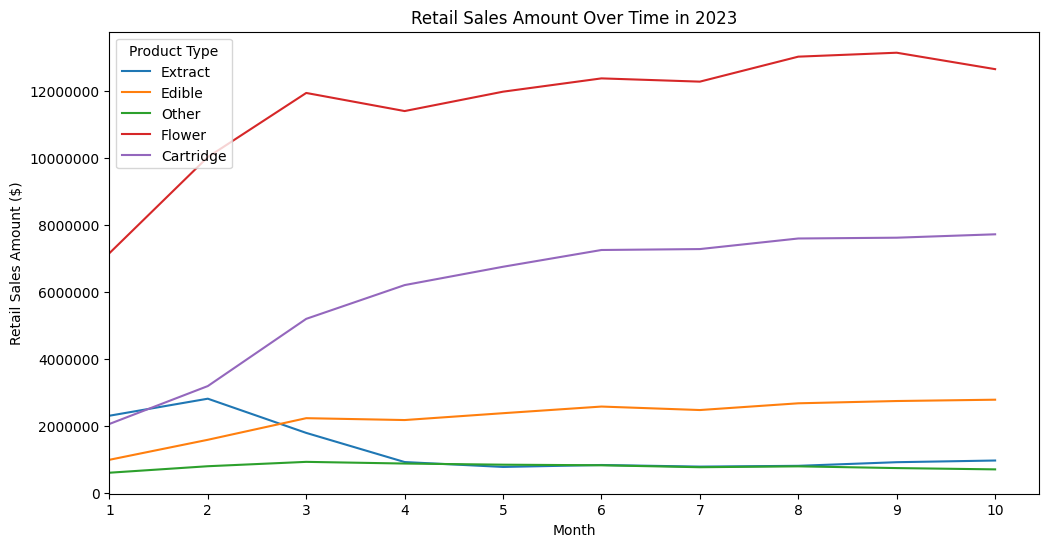

In [31]:
# Group retail sales by month and product type to get monthly sales for each category
product_grouped = product_df.groupby(["Month","Product Type"])["Retail Sales Amount"].sum()
product_grouped

# Pivot grouped data into wide format for line plotting
product_pivot = product_grouped.unstack(level="Product Type")
product_pivot

# Custom formatter to display y-axis values as raw numbers
def raw_value_formatter(value, tick_number):
    return f'{int(value)}'


# Plot multiple line chart for each category of product type
plt.figure(figsize=(12,6))

for product_type in product_pivot.columns:
    plt.plot(product_pivot.index, product_pivot[product_type], label=product_type)

# Set y-axis to display raw values
plt.gca().yaxis.set_major_formatter(FuncFormatter(raw_value_formatter))

# Set x-axis to display every month tick
plt.xticks(product_pivot.index)
plt.xlim(left=1)
plt.title('Retail Sales Amount Over Time in 2023')
plt.xlabel('Month')
plt.ylabel('Retail Sales Amount ($)')
plt.legend(title='Product Type', loc="upper left")
plt.show()

***Analysis: Retail Sales Over Time by Product Type***

Differences in retail sales over time are observed between product types. Notably, "flower" products show the highest retail sales every month; followed by "cartridge", "extract", "edible", and "other" products respectively.

Additionally, product categories show different trends in retail sales. "flower", "cartridge", and "edible" products show an increasing trend in retail sales through the year. Whereas, "extract" products show a decreasing trend  while "other" remains constant in retail sales. 

2b. Box plot of retail sales for each category of product type

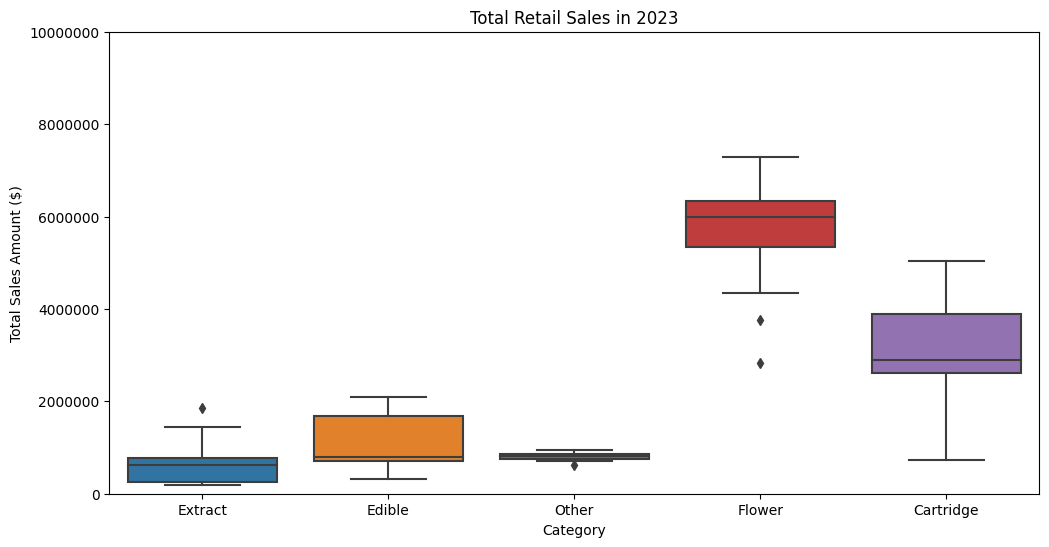

In [32]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Product Type', y='Retail Sales Amount', data=product_df)
# Custom color palette
custom_palette= ["blue","orange","green","red", "purple"]
plt.ylim(0,10000000)
plt.gca().yaxis.set_major_formatter(FuncFormatter(raw_value_formatter))
plt.ylabel("Total Sales Amount ($)")
plt.xlabel("Category")
plt.title('Total Retail Sales in 2023')

plt.show()

***Analysis: Total Retail Sales by Product Type***

The spread of total retail sales appears the same for "flower", "cartridge", "extract", and "edible" cannabis products. However, the spread is the tightest for "other" cannabis products.

The average total retail sales is the highest for "flower" products; followed by "cartridge", "edible", "extract", and "other" cannabis products. This boxplot suggests that the largest difference between means may exist between "flower" vs "extract","edible", and "other" products.


**EDA Summary:**

1. Total Retail Sales over Time
2. Total Retail Sales over Time by Product Type 

## Time Series Forecasting - Total Cannabis Retail Sales

---

In [33]:
# Remove duplicate column for week ending; week ending serves as index
sales_df = sales_df.drop(columns=['Week Ending'])

# Remove duplicate column for month ending; month ending serves as index
product_df = product_df.drop(columns=['Month Ending'])


In [34]:
# Remove duplciated periods in sales_df
sales_df = sales_df[~sales_df.index.duplicated(keep='first')]

# Remove duplicated periods in product_df
product_df = product_df[~product_df.index.duplicated(keep='first')]

### Single Exponential Smoothing - Total Cannabis Retail Sales

In [35]:
# Split the data into testing and training sets
# Define the forecasting horizon
# Instantiate a exponential smoothing forecaster
# Fit the exponential smoothing forecaster to training set
# Make prediction using the exponential smoothing forecaster

In [36]:
# Plot exponential smoothing

### Auto Arima - Total Cannabis Retail Sales

In [37]:
# Split the data into testing and training sets
y_train, y_test = temporal_train_test_split(sales_df["Total Adult-Use and Medical Sales"])

# Define the forecasting horizon
fh = ForecastingHorizon(y_test.index, is_relative=False)

# Instantiate a AutoARIMA forecaster
Auto_Arima = AutoARIMA(suppress_warnings=True)

# Fit the AutoARIMA forecaster to training set
Auto_Arima.fit(y_train)

# Make prediction using the AutoARIMA forecaster
y_pred = Auto_Arima.predict(fh)

# Evaluate the model
error = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error: ', round(error,2))


Mean Absolute Error:  1396844.19


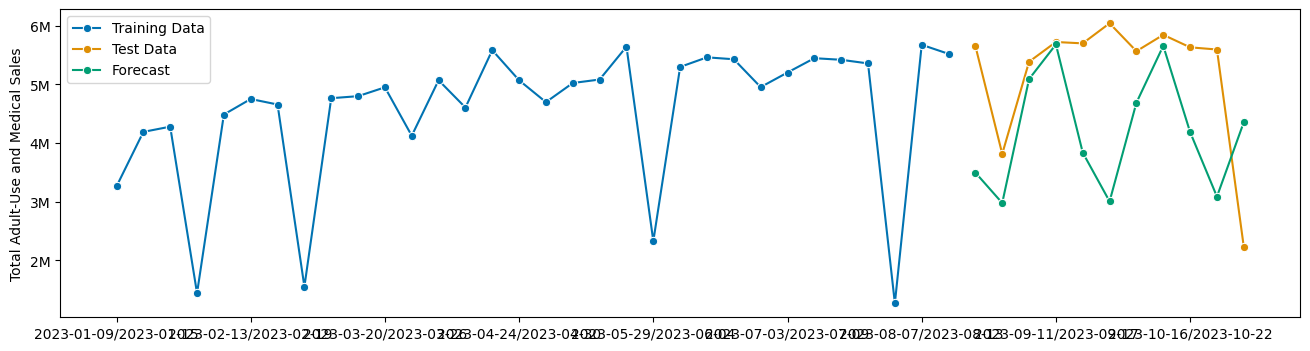

In [53]:
# Visualize results of Auto ARIMA
plot_series(y_train, y_test, y_pred, labels=["Training Data", "Test Data", "Forecast"])
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))


#### Model Comparions: Single Exponential Smoothing vs ARIMA

## Time Series Forecasting - Cannabis Sales by Product Type

## Exponential Smoothing - Flower

## AUTO ARIMA - Flower Products

## Results

---

## Implications

---

## Future Directions

---

# Bibliography

***

Hasin, D., & Walsh, C. (2021). Trends over time in adult cannabis use: A    review of recent findings. Current Opinion in Psychology, 38, 80–85. https://doi.org/10.1016/j.copsyc.2021.03.005

Midgette, G.,Davenport, S., Caulkins, J., Kilmer, B. (2019). What America’s Users Spend on Illegal Drugs, 2006–2016.RAND Corporation. https://www.rand.org/pubs/research_reports/RR3140.html.

National Academies of Sciences, Engineering, and Medicine, Health and Medicine Division, Board on Population Health and Public Health Practice, & Evidence, A. (2017, January 12). Challenges and Barriers in Conducting Cannabis Research. Nih.gov; National Academies Press (US). https://www.ncbi.nlm.nih.gov/books/NBK425757/

Soloveichick, R. (2021). Tracking Marijuana in the National Accounts. (Working Paper No. WP2021-05). https://www.bea.gov/index.php/system/files/papers/BEA-WP2021-5.pdf